In [1]:
import glob, os, subprocess

import numpy       as np
import nibabel     as nib
import pandas      as pd
import matplotlib.pyplot  as plt
import seaborn     as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats   import norm

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# statsmodel function for later
def loglog_model(vert, mask, df, model='RLM'):
    """
    runs linear models of areal scaling
    
    vert: vertex id
    mask: cortical mask for all vertices, 1=in cortex
    df: subject info for model
    model: 'rlm' or 'mixed'
    """
    
    if mask[vert] > 0:
        if model == 'OLS':
            # linear model (ignores repeated measures)
            vert_mdl = smf.ols("vert{:} ~ 1 + log_total".format(vert), df, missing='drop')
            vert_mdf = vert_mdl.fit()
        elif model == 'RLM':
            # robust linear model 
            vert_mdl = smf.rlm("vert{:} ~ 1 + log_total".format(vert), df, missing='drop')
            vert_mdf = vert_mdl.fit()
        else:
            assert model=='MIXED'
            vert_mdl = smf.mixedlm("vert{:} ~ 1 + log_total".format(vert), df, groups=df['subject'], missing='drop')
            vert_mdf = vert_mdl.fit()

        # return scaling coefficient
        return vert_mdf.params['log_total']
    else:
        return 0

# all subject with more that 5% outliers have already been removed
def remove_outliers(data, window=25, min_window=5, thr=3):
    # identify outliers in a pandas Series based on a sliding window
    d = data.copy()
    r = d.rolling(window, min_periods=min_window, center=True)
    # identify points more the stdev*thr away from the mean within the window
    outliers = np.logical_or((d  > (r.mean() + (thr*r.std()))), (d  < (r.mean() - (thr*r.std()))))
    # set to nan
    d.iloc[outliers] = np.nan
    
    return d


def get_parcel_data(data, label_img, data_label='data', add_one=True):
    """
    data: vector of vertex level data
    label_img: gifti format label image

    return: parcel_data, vector of n labels, average data in each parcel
    """

    # Iterate over the labels and keys
    label_name = []
    label_key = []
    data_median = []
    data_lower = []
    data_upper = []
    for label in label_img.labeltable.labels:
        if (label.label == '???') or (label.label == 'brain_tissue'):
            continue
        else:
            parcel_median = np.nanmedian(data[label_img.darrays[0].data == label.key])
            parcel_lower = np.nanpercentile(data[label_img.darrays[0].data == label.key], 25)
            parcel_upper = np.nanpercentile(data[label_img.darrays[0].data == label.key], 75)

            label_name.append(label.label)
            label_key.append(label.key)
            data_median.append(parcel_median + 1) if add_one else data_median.append(parcel_median)
            data_lower.append(parcel_lower + 1) if add_one else data_lower.append(parcel_median)
            data_upper.append(parcel_upper + 1) if add_one else data_upper.append(parcel_median)

    return pd.DataFrame(zip(label_name, label_key, data_median, data_lower, data_upper), columns=['name','label', '{:}_median'.format(data_label), '{:}_lower'.format(data_label), '{:}_upper'.format(data_label)])


def get_parcel_image(data, label_file, metric_file):
    """
    averages values within a parcel and paints onto metric file
    data: vector, 1 value per vertex
    label_img: gifti, gifti format label image
    metric_file: gifti, shape shape as label_file, data arrays will be overwritten by parcellated data

    return
    data_metric: gifti, parcellated data
    """
    vertex_labels = label_file.darrays[0].data.copy().astype(float)

    # Iterate over the labels and keys
    for label in label_file.labeltable.labels:
        if (label.label == '???') or (label.label == 'brain_tissue'):
            continue
        else:
            vertex_labels[vertex_labels==label.key] = np.nanmedian(data[vertex_labels==label.key])
        
    metric_file.darrays[0].data = vertex_labels

    return metric_file

colour_lut = [[145, 0, 55],
              [203, 41, 58],
              [255, 117, 104],
              [134, 0, 39],
              [102, 41, 0],
              [255 , 205, 104],
              [222, 108, 37],
              [43, 157, 49],
              [1, 224, 176],
              [184, 107, 0],
              [128, 85, 0],
              [45, 91, 207],
              [255, 189, 131],
              [255, 126, 196],
              [90,57, 170],
              [153, 14, 220],
              [0, 181, 252],
              [116, 63, 121],
              [255, 162, 100],
              [226, 215, 103],
              [174, 63, 174],
              [244, 143, 255],
              [2, 133, 219],
              [0, 68, 136],
              [112, 0, 119],
              [14, 26, 140],
              [173, 156, 255],
              [166, 0, 118],
              [119, 0, 91]]

In [4]:
# DATAPATHS
# location of dHCP fetal MRI subject data
mri_data_path = 'XXX/dHCP_fetal/'
# location of dHCP fetal atlas
ubrain_path = 'XXX/surface_registration/'

# check labels on template surface are where expected - download if needed
assert os.path.isfile('surface_data/ubrain-labels-to-fetal36-template.label.gii')

# OUTPATHS
out_dir = 'OUTPUTS/'
results_dir = 'RESULTS/'


# ALTERNATIVE MODEL 
model = 'OLS' #'OLS'  'RLM' or 'MIXED'

# drop repeats - remove repeated scans?
drop_repeats=False
repeats='-no-repeats' if drop_repeats else ''


## Areal scaling during the third trimester
Cortical expansion is a critical developmental process that occurs from mid-gestation onwards. Cortical surface area increases exponentially across the third trimester as the cortex folds and increases in volume. Here, we test regional variation in cortical [allometric scaling](https://pubmed.ncbi.nlm.nih.gov/29853553/) using linear log-log models of vertex area as a function of total cortical surface area.  

$$log_{10}(area_{vertex})= \beta_1 log_{10}(area_{total}) + \epsilon $$

195 datasets available from 190 subjects


  0%|          | 0/195 [00:00<?, ?it/s]

average cortical mask: /data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//cortical-mask.shape.gii

loading area data


  0%|          | 0/195 [00:00<?, ?it/s]

subject area data: /data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//subject-vertex-area-data.npy
vertex outliers: /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//cortical-area-outliers.png


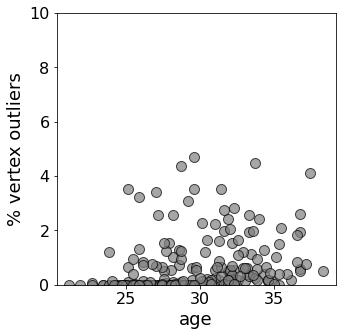

In [5]:
# LOAD SUBJECT DATA ###############################################################
# image data
subject_info = pd.read_csv(mri_data_path + 'all_subject_qc.csv')
    
# keep those that passed QC - based on registration and ubrain labelling quality and area outliers
subject_info = subject_info[subject_info.USE==1]

if drop_repeats: # keep earliest scans for all subjects with >1 scan 
    subject_info = subject_info.groupby('sub').first().reset_index()

print('{:} datasets available from {:} subjects'.format(len(subject_info),len(subject_info['sub'].unique())))

# CREATE AVERAGE CORTICAL MASK ####################################################
# create cortical surface mask using average of individual masks
surface_metric = nib.load('{:}/fetal_atlas/fetal.week36.right.sulc.shape.gii'.format(ubrain_path))
average_mask = np.zeros_like(surface_metric.darrays[0].data)

for i in tqdm(np.arange(len(subject_info))):
    sub = subject_info.iloc[i]['sub']
    ses = subject_info.iloc[i]['ses']
    subject_mask = nib.load('{:}subject-data/sub-{:}/ses-{:}/anat/sub-{:}_ses-{:}_hemi-right.dHCP_fetal36.desc-medialwall_mask.shape.gii'.format(mri_data_path, sub, ses, sub, ses))
    average_mask += subject_mask.darrays[0].data

# keep all vertices in cortex for at least 25% of subjects
average_mask = ((average_mask / len(subject_info))) > 0.25

# save out
surface_metric.darrays[0].data = average_mask
print('average cortical mask: {:}/cortical-mask{:}.shape.gii'.format(out_dir, repeats))
nib.save(surface_metric, '{:}/cortical-mask{:}.shape.gii'.format(out_dir, repeats))


# LOAD AREA DATA #################################################################
all_age = []
all_area = []

print()
print('loading area data')
for i in tqdm(np.arange(len(subject_info))):
    sub = subject_info.iloc[i]['sub']
    ses = subject_info.iloc[i]['ses']
    age = subject_info.iloc[i]['accGA']
    
    area_data = '{:}subject-data/sub-{:}/ses-{:}/anat/sub-{:}_ses-{:}_hemi-right.dHCP_fetal36.smoothed-corr-area.shape.gii'.format(mri_data_path, sub, ses, sub, ses)
    subject_area = nib.load('{:}'.format(area_data)).darrays[0].data
    
    all_age.append(age)
    all_area.append(subject_area)
    
    
        
# REMOVE OUTLIERS IN AGE_BASED SLIDING WINDOWS ######
# sort area by age
age_index = np.argsort(all_age)
reorder = np.argsort(age_index)

sorted_age = np.array(all_age)[age_index]
sorted_area = np.array(all_area)[age_index,:]

# remove outliers based on sliding window over age
sorted_area = pd.DataFrame(sorted_area).apply(remove_outliers, axis=0, args=(25, 10, 2.5))

# put back in original order
all_area = sorted_area.iloc[reorder, :].values

# total area (for all vertices in mask)
all_total_area = np.nansum(all_area[:,average_mask==1], axis=1)
    
# save out area as numpy array
print('subject area data: {:}/subject-vertex-area-data{:}.npy'.format(out_dir, repeats))
np.save('{:}/subject-vertex-area-data{:}.npy'.format(out_dir, repeats), all_area)    


# save out outliers per subect
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(subject_info.accGA, 100*(np.sum(np.isnan(all_area), 1)/np.shape(all_area)[1]), 
           s=100, alpha=.7, facecolor='grey', edgecolor='black')
ax.set_ylim(0, 10)
ax.tick_params('both', labelsize=16)
ax.set_ylabel('% vertex outliers', fontsize=18)
ax.set_xlabel('age', fontsize=18)

print('vertex outliers: {:}/cortical-area-outliers{:}.png'.format(results_dir, repeats))
plt.savefig('{:}/cortical-area-outliers{:}.png'.format(results_dir, repeats), transparent=False, facecolor='white', dpi=300)



log-log scaling of cortical surface area: /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//logarithmic-cortical-area.png


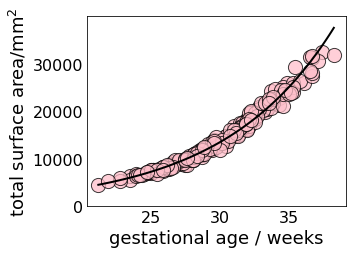

In [6]:
# PLOT #############################################################################3
fig, ax = plt.subplots(1,1, figsize=(5, 3.5))
# plot total area
ax.scatter(all_age, all_total_area, s=200, edgecolor='black', facecolor='pink', alpha=0.75)

# formatting
ax.set_ylim(0,40000)
ax.set_ylabel(r'total surface area/mm$^2$', fontsize=18)
ax.set_yticks(np.arange(0, 40000, 10000))
ax.set_xlabel('gestational age / weeks', fontsize=18)
ax.tick_params(which='both', labelsize=16, length=0)

# fit log model to data
df = pd.DataFrame((all_age, np.log10(all_total_area))).T
df.columns = ['age', 'tsa']
df = sm.add_constant(df)
mdl = smf.glm('tsa ~ age', df)
mdf = mdl.fit()

# plot log model
x = np.linspace(np.min(df['age']), np.max(df['age']), 100)
y = np.linspace(np.min(df['tsa']), np.max(df['tsa']), 100)
dummy_df = pd.DataFrame((x, y)).T
dummy_df.columns = ['age', 'tsa']
dummy_df = sm.add_constant(dummy_df)
predicted_area = 10**(mdf.predict(dummy_df))
ax.plot(x, predicted_area, linewidth=2, color='black')

# save out
plt.tight_layout()
print()
print('log-log scaling of cortical surface area: {:}/logarithmic-cortical-area{:}.png'.format(results_dir, repeats))
plt.savefig('{:}/logarithmic-cortical-area{:}.png'.format(results_dir, repeats), transparent=False, facecolor='white', dpi=300)


### Fitting vertex level models to area data

In [ ]:
# LOAD DATA ######################################################################
# load vertex and mask data
all_area = np.load('{:}/subject-vertex-area-data{:}.npy'.format(out_dir, repeats))
mask_img = nib.load('{:}/cortical-mask{:}.shape.gii'.format(out_dir, repeats))
mask_vertices = mask_img.darrays[0].data


# CREATE DATAFRAMES FOR MODELS ####################################################
# create dataframe for all subjects vertex-wise area data
all_area_df = pd.DataFrame(np.log10(np.where(all_area>0, all_area, np.nan))) # no negatives
all_area_df.columns = ['vert{:}'.format(v) for v in np.arange(np.shape(all_area)[1])] 

# append subject age, total cortical area
all_total_area = np.nansum(all_area[:,mask_vertices==1], axis=1)
model_df = pd.DataFrame((subject_info['sub'].values, subject_info['accGA'].values, all_total_area, np.log10(all_total_area))).T
model_df.columns=['subject', 'age', 'total_cortical_area', 'log_total']
model_df = pd.concat((model_df, all_area_df), axis=1)
model_df[model_df.columns[1:]] = model_df[model_df.columns[1:]].apply(pd.to_numeric)
    
    
 


    

# RUN MODELS #######################################################################
# fit linear models to each vertex (ignore midline)
print('')
print('running vertexwise models')
scaling_coef = Parallel(n_jobs=-1)(
                   delayed(loglog_model)(vert, mask_vertices, model_df, model) for vert in np.arange(np.shape(all_area)[1]))

# subtract 1 so that +ve is hyper allometric, and -ve is hypo allometric
coef_data = np.stack([c -1 for c in scaling_coef]) * np.stack(mask_vertices)

# save out image
mask_img.darrays[0].data = coef_data
print('cortical scaling: {:}/cortical-corr-area-scaling-{:}{:}.shape.gii'.format(out_dir, model, repeats))
nib.save(mask_img, '{:}/cortical-corr-area-scaling-{:}{:}.shape.gii'.format(out_dir, model, repeats))  


# save out outliers per vertex as image
mask_img.darrays[0].data = np.sum(np.isnan(all_area), 0)
print('outliers: {:}/area-outliers{:}.shape.gii'.format(out_dir, model, repeats))
nib.save(mask_img, '{:}/area-outliers{:}.shape.gii'.format(out_dir, model, repeats))  




# GET AVERAGE SCALING FOR EACH CORTICAL PARCEL #####################################
# load ubrain labels
label_img = nib.load('surface_data/ubrain-labels-to-fetal36-template.label.gii')

# parcellated data and image
scaling_df = get_parcel_data(coef_data, label_img, data_label='scaling')
label_scaling = get_parcel_image(coef_data, label_img, mask_img)

# output image
print('parcellated areal scaling: {:}/cortical-corr-area-parcellated-scaling-{:}{:}.shape.gii'.format(out_dir, model, repeats))
nib.save(mask_img, '{:}/cortical-corr-area-parcellated-scaling-{:}{:}.shape.gii'.format(out_dir, model, repeats))   

# output scaling
print()
print('parcellated areal scaling data: {:}/cortical-corr-area-parcellated-scaling-{:}{:}.csv'.format(results_dir, model, repeats))
scaling_df.to_csv('{:}/cortical-corr-area-parcellated-scaling-{:}{:}.csv'.format(results_dir, model, repeats), index=None)
